In [1]:
import zipfile
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

SEED = 4

# Load split data

In [2]:
!wget 'https://github.com/jkorzeniovski/projekt_zesp/raw/main/data/skin_diseases_split.zip'

--2023-11-30 16:47:10--  https://github.com/jkorzeniovski/projekt_zesp/raw/main/data/skin_diseases_split.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/jkorzeniovski/projekt_zesp/main/data/skin_diseases_split.zip [following]
--2023-11-30 16:47:10--  https://media.githubusercontent.com/media/jkorzeniovski/projekt_zesp/main/data/skin_diseases_split.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317059351 (302M) [application/zip]
Saving to: ‘skin_diseases_split.zip’

skin_diseases_split 100%[===================>] 302.37M   242MB/s    in 1.3s    

2023-11-30 16:47:18 (242 M

In [3]:
zip_ref = zipfile.ZipFile('skin_diseases_split.zip')
zip_ref.extractall()
zip_ref.close()

# Process Images

In [4]:
TRAIN_DIR = "/content/data/train"
VAL_DIR = "/content/data/val"
TEST_DIR = "/content/data/test"

CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
CLASSES_NUM = len(CLASS_NAMES)

INPUT_SHAPE = (192,192,3)
IMG_SIZE=INPUT_SHAPE[:2]
EPOCHS=20
BATCH_SIZE=32

In [5]:
# Use ImageDataGenerator for loading and preprocessing images
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to be between 0 and 1
    shear_range=0.2,          # Apply random shear transformations
    zoom_range=0.2,           # Apply random zoom transformations
    horizontal_flip=True,     # Flip images horizontally
    rotation_range=45,        # Rotate
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images in batches from the directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2340 images belonging to 19 classes.
Found 269 images belonging to 19 classes.
Found 691 images belonging to 19 classes.


# Model Training

In [6]:
base_model = DenseNet121(include_top=False,
                        weights='imagenet',
                        input_shape=INPUT_SHAPE,
                        classes=CLASSES_NUM,)

# Freeze layers
for layer in base_model.layers:
  layer.trainable = False

# Create a model on top of pretrained one.
model = Sequential([
    base_model,
    Flatten(),
    Dense(1026, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(CLASSES_NUM, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

early_stopping_cb = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor, can be 'val_loss', 'val_accuracy', etc.
    factor=0.4,            # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1              # 1: update messages, 0: silent
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs = 50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping_cb, reduce_lr]
)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
73/73 [==============================] - 407s 5s/step - loss: 2.9442 - accuracy: 0.2721 - val_loss: 4.0857 - val_accuracy: 0.2930 - lr: 0.0010
Epoch 2/50
73/73 [==============================] - 395s 5s/step - loss: 2.1553 - accuracy: 0.3947 - val_loss: 2.2894 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 3/50
73/73 [==============================] - 400s 5s/step - loss: 1.9246 - accuracy: 0.4333 - val_loss: 2.1218 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 4/50
73/73 [==============================] - 392s 5s/step - loss: 1.8003 - accuracy: 0.4710 - val_loss: 2.0075 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 5/50
73/73 [==============================] - 402s 5s/step - loss: 1.7083 - accuracy: 0.4874 - val_loss: 1.9866 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 6/50
73/73 [==============================] - 390s 5s/step - loss: 1.6625 - accuracy: 0.4905 - val_loss: 2.0512 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 7/50


# Model Evaluation

### Accuracy and Loss

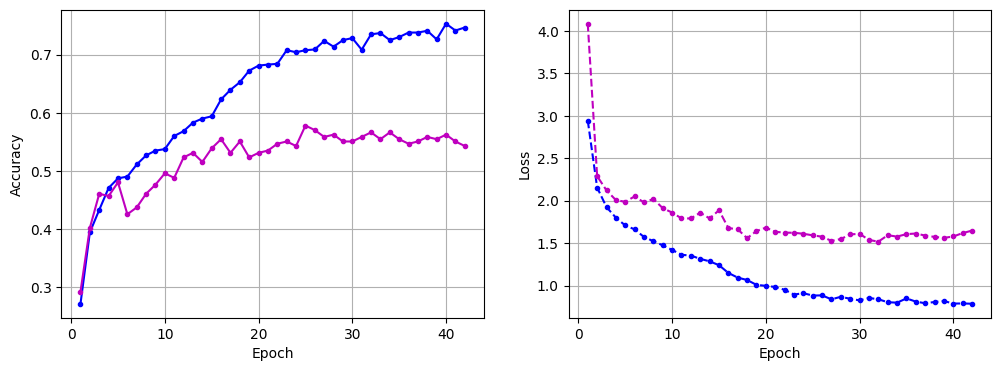

In [7]:
# Plot history
plt.figure(figsize=(12,4))

num_epochs_trained = len(history.history['accuracy'])
# Accuracy vs. epochs
plt.subplot(121, xlabel='Epoch', ylabel='Accuracy')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['accuracy'], 'b.-', label='Training accuracy')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['val_accuracy'], 'm.-', label='Validation accuracy')
plt.grid(True)

# Loss vs. epochs
plt.subplot(122, xlabel='Epoch', ylabel='Loss')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['loss'], 'b.--', label='Training loss')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['val_loss'], 'm.--', label='Validation loss')
plt.grid(True)

In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 [==============================] - 105s 5s/step - loss: 1.6626 - accuracy: 0.5506
Test Accuracy: 55.06%


### Confusion Matrix

In [9]:
true_labels = []
predicted_labels = []

# Use the model to predict labels for the test set
for i in range(test_generator.samples // BATCH_SIZE):
  images, labels = next(test_generator)
  true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to integers
  predictions = model.predict(images)
  predicted_labels.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 4s 4s/step


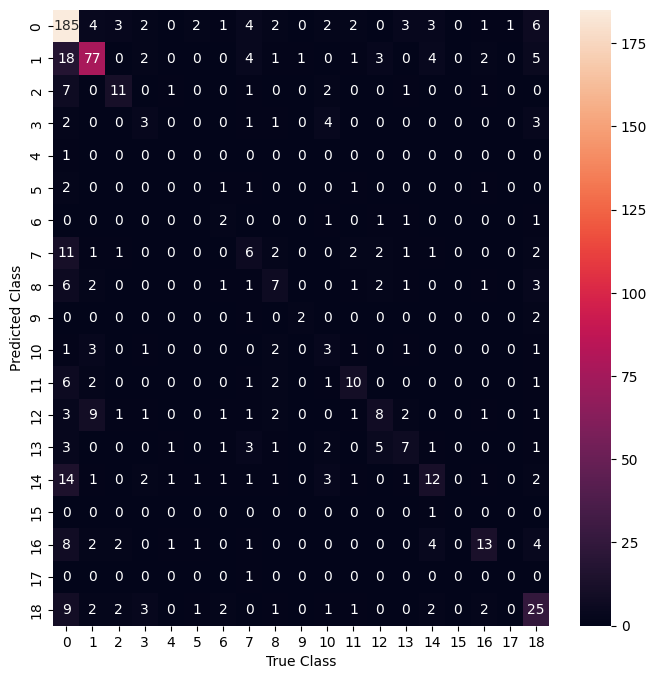

In [10]:
# Show confusion matrix based on predictions
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=plt.gca())
plt.gca().set(xlabel="True Class", ylabel="Predicted Class");

In [11]:
# print labels and encoded labels

### Grad-CAM (Gradient-weighted Class Activation Mapping)
We will visualize the regions of the input images that the model focuses on during prediction. This will show which parts of the image are important for the model's decision.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 1026)              37823490  
                                                                 
 batch_normalization (Batch  (None, 1026)              4104      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1026)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               525824    
                                                        

In [ ]:
base_model.summary()

In [14]:
def get_grad_cam(model, img_path, class_index):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=INPUT_SHAPE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.nasnet.preprocess_input(img_array)

    # Get the last convolutional layer and the output layer
    last_conv_layer = model.get_layer("densenet121").get_layer("relu")
    classifier_layer = model.layers[-1]

    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer_model = tf.keras.models.Model(model.get_layer("densenet121").inputs, last_conv_layer.output)

    # Create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = model.get_layer("flatten")(x)
    x = model.get_layer("dense")(x)
    x = model.get_layer("batch_normalization")(x)
    x = model.get_layer("dropout")(x)
    x = model.get_layer("dense_1")(x)
    x = model.get_layer("batch_normalization_1")(x)
    x = model.get_layer("dense_2")(x)
    classifier_model = tf.keras.models.Model(classifier_input, x)

    # Compute the gradient of the top predicted class for the specified class index
    with tf.GradientTape() as tape:
        # Get the feature map of the last conv layer
        last_conv_layer_output = last_conv_layer_model(img_array)
        # Make the model output predictions for the input image
        preds = classifier_model(last_conv_layer_output)
        # Retrieve the prediction for the specified class index
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Obtain the gradient of the top class with respect to the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the top class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average the resulting heatmap along the channel dimension to obtain the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(img_array[0]), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    return superimposed_img

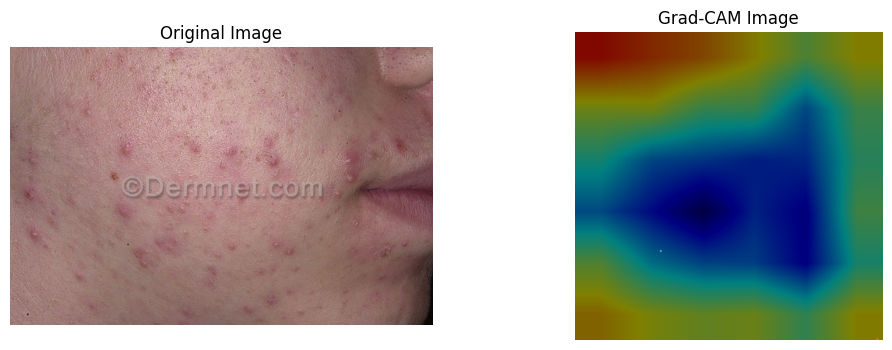

In [15]:
# Example usage
img_path = '/content/data/train/Acne and Rosacea Photos/07Acne081101.jpg'
class_index = 0  # Replace with the class index you are interested in
grad_cam_img = get_grad_cam(model, img_path, class_index)

# Load the original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display the original and Grad-CAM images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(grad_cam_img)
axes[1].set_title('Grad-CAM Image')
axes[1].axis('off');